In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

%matplotlib inline
pd.pandas.set_option('display.max_columns', None)

/Users/kamilmysiak/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/kamilmysiak/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/kamilmysiak/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  depreca

In [2]:
#Reading in data
with open('opioid_use_data.csv') as f:
    df = pd.read_csv(f)
f.close()

/Users/kamilmysiak/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
SEED = 42

In [ ]:
print(df.shape)

In [ ]:
df.info()

In [ ]:
df.head()

## Deleting Initial Features
- Delete features which have all unique observiations, which are highly correlated and/or have 90-95% of missing values

In [ ]:
# We can remove ClaimID since each observation has a unique value
for var in df.columns:
    print(var, df[var].nunique(), len(df))

In [4]:
df.drop('ClaimID', axis=1, inplace=True)

In [5]:
# Highly correlated features can be removed
df_copy = df.copy()
corr_matrix = df_copy.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,Accident DateID,Claim Setup DateID,Report To DateID,Employer Notification DateID,Industry ID,Claimant Age,Number Dependents,Weekly Wage,Max Medical Improvement DateID,Percent Impairment,Post Injury Weekly Wage,Surgery Flag,Accident Source Code,Neurology Payment Flag,Neurosurgery Payment Flag,Dentist Payment Flag,Orthopedic Surgery Payment Flag,Psychiatry Payment Flag,Hand Surgery Payment Flag,Optometrist Payment Flag,Podiatry Payment Flag,HCPCS A Codes,HCPCS B Codes,HCPCS C Codes,HCPCS D Codes,HCPCS E Codes,HCPCS F Codes,HCPCS G Codes,HCPCS H Codes,HCPCS I Codes,HCPCS J Codes,HCPCS K Codes,HCPCS L Codes,HCPCS M Codes,HCPCS N Codes,HCPCS O Codes,HCPCS P Codes,HCPCS Q Codes,HCPCS R Codes,HCPCS S Codes,HCPCS T Codes,HCPCS U Codes,HCPCS V Codes,HCPCS W Codes,HCPCS X Codes,HCPCS Y Codes,HCPCS Z Codes,ICD Group 1,ICD Group 2,ICD Group 3,ICD Group 4,ICD Group 5,ICD Group 6,ICD Group 7,ICD Group 8,ICD Group 9,ICD Group 10,ICD Group 11,ICD Group 12,ICD Group 13,ICD Group 14,ICD Group 15,ICD Group 16,ICD Group 17,ICD Group 18,ICD Group 19,ICD Group 20,ICD Group 21,CPT Category - Anesthesia,CPT Category - Eval_Mgmt,CPT Category - Medicine,CPT Category - Path_Lab,CPT Category - Radiology,CPT Category - Surgery,NDC Class - Benzo,NDC Class - Misc (Zolpidem),NDC Class - Muscle Relaxants,NDC Class - Stimulants,Opiods Used
Accident DateID,NaN,0.992483,0.993462,0.995020,0.004154,0.010695,0.036018,0.010670,0.903402,0.134289,0.049074,0.135031,0.054814,0.038273,0.037529,0.019431,0.091537,0.057880,0.018759,0.004128,0.066799,0.085595,0.004589,0.010104,0.006228,0.108151,0.033867,0.030992,0.005061,0.008981,0.066734,0.016273,0.068934,0.103838,0.049762,0.018378,0.043105,0.036460,0.008612,0.034857,0.029229,0.001773,0.007001,0.094704,0.003217,0.002318,0.049492,0.039893,0.037396,0.028689,0.040333,0.071203,0.171896,0.033241,0.033784,0.066827,0.047526,0.067651,0.054951,0.315585,0.038981,0.008637,0.014260,0.039070,0.135190,0.052350,0.031032,0.186262,0.124726,0.160121,0.190538,0.106322,0.135261,0.149116,0.044144,0.052774,0.070667,0.001963,0.145555
Claim Setup DateID,NaN,NaN,0.999172,0.997141,0.003075,0.004492,0.041018,0.007758,0.911597,0.127034,0.044831,0.136179,0.056502,0.038616,0.038605,0.020792,0.096506,0.061228,0.019982,0.006546,0.069855,0.089091,0.005886,0.012562,0.003996,0.109118,0.033712,0.029270,0.005735,0.006528,0.072640,0.016624,0.076742,0.091498,0.051455,0.018336,0.043757,0.039663,0.007898,0.037829,0.016988,0.001232,0.007632,0.099099,0.000462,0.001960,0.047623,0.041074,0.040108,0.031985,0.042532,0.076875,0.177359,0.035814,0.035641,0.072057,0.051272,0.072338,0.060656,0.332064,0.041857,0.010600,0.014043,0.042083,0.144563,0.061913,0.032623,0.199341,0.130649,0.176621,0.193041,0.107506,0.140116,0.154839,0.043585,0.052496,0.073857,0.001477,0.147656
Report To DateID,NaN,NaN,NaN,0.997972,0.003196,0.005053,0.040825,0.008037,0.911207,0.127554,0.044856,0.135707,0.056373,0.038550,0.038562,0.020794,0.096098,0.061112,0.019748,0.006329,0.069654,0.088358,0.005850,0.012360,0.003884,0.108746,0.033553,0.029431,0.005795,0.006528,0.072018,0.016496,0.075972,0.091741,0.051531,0.018322,0.043714,0.039290,0.007914,0.037552,0.017190,0.001236,0.007636,0.099280,0.000589,0.001946,0.047787,0.040998,0.040109,0.031834,0.042384,0.076908,0.177104,0.035678,0.035569,0.071881,0.051053,0.072168,0.060427,0.331684,0.041741,0.010529,0.014000,0.041984,0.144216,0.061503,0.032521,0.198877,0.130218,0.174589,0.192106,0.107225,0.139071,0.154095,0.043639,0.052403,0.073427,0.001432,0.147189
Employer Notification DateID,NaN,NaN,NaN,NaN,0.003700,0.005873,0.040124,0.008282,0.908647,0.129576,0.045137,0.136051,0.057146,0.038167,0.038300,0.020343,0.095763,0.060964,0.019722,0.006098,0.069111,0.086754,0.005799,0.012028,0.003462,0.108258,0.033666,0.029069,0.005694,0.007358,0.070926,0.016203,0.074218,0.093612,0.051077,0.018320,0.043691,0.038263,0.007734,0.037137,0.018760,0.001185,0.007918,0.097908,0.000971,0.001885,0.047889,0.040780,0.040103,0.031602,0.042154,0.077236,0.177495,0.035389,0.035578,0.071497,0.0

In [6]:
to_drop = [var for var in upper.columns if any(upper[var] > .90)]
to_drop

['Claim Setup DateID',
 'Report To DateID',
 'Employer Notification DateID',
 'Max Medical Improvement DateID']

In [7]:
df.drop(df[to_drop], axis=1, inplace=True)

In [ ]:
# Let's examine if any features have 90-95% of missing values
for var in df.columns:
    print(var, 'percent of missing values', df[var].isnull().mean().round(3))

In [ ]:
states = pd.DataFrame(df[['Claimant State', 'Accident State', 'Benefits State']])
states

In [8]:
df.drop(['Claimant State', 'Accident State'], axis=1, inplace=True)

In [ ]:
# Data issues to be addressed:
# 1. Blanks need to be converted to np.nan
# 2. Accident Type Group is a mixed type feature and will need to be separated out
# 3. Some features have "X" which we can assume are missing values and can converted as np.nan
for var in df.columns:
    print(var, df[var].unique(), '\n')

In [ ]:
# Converting nulls to np.nan
for var in df.columns:
    df[var].replace(to_replace='  ', value=np.nan, inplace=True)

In [ ]:
# Converting values of "X" to np.nan
for var in df.columns:
    df[var].replace(to_replace='X', value=np.nan, inplace=True)

In [9]:
# Splitting out "Accident Type Group" (ie. mixed type feature) into separate features
# Dropping the original "Accident Type Group" feature
df['Accident Type Group num'] = df['Accident Type Group'].str.extract('(\d+)')
df['Accident Type Group str'] = df['Accident Type Group'].str[0:5]
df.drop(['Accident Type Group'], axis=1, inplace=True)

In [ ]:
# Let's examine the cardinality (ie. the number of unique values/categories) of each feature to determine 
#  if any categories hold the majority of the values
# Features w/categories which hold 90%+ of values don't have enough variability and can be removed
for var in df.columns:
    print(var,'\n', df[var].value_counts()/len(df))

In [10]:
# We can drop 'Neurology Payment Flag', 'Neurosurgery Payment Flag', 'Dentist Payment Flag',
# 'Psychiatry Payment Flag', 'Hand Surgery Payment Flag', 'Optometrist Payment Flag',
# 'Podiatry Payment Flag', 'Accident Type Group str' because 90%+ of the values are the same
df.drop(['Neurology Payment Flag', 'Neurosurgery Payment Flag', 'Dentist Payment Flag',
         'Psychiatry Payment Flag', 'Hand Surgery Payment Flag', 'Optometrist Payment Flag',
         'Podiatry Payment Flag', 'Accident Type Group str', 'Post Injury Weekly Wage'], axis=1, inplace=True)

In [11]:
# We can drop many of the discrete features as well
df.drop(['HCPCS B Codes','HCPCS C Codes', 'HCPCS D Codes', 'HCPCS F Codes', 'HCPCS H Codes', 'HCPCS I Codes',
'HCPCS K Codes', 'HCPCS M Codes', 'HCPCS N Codes', 'HCPCS O Codes', 'HCPCS P Codes',
'HCPCS Q Codes', 'HCPCS R Codes', 'HCPCS S Codes', 'HCPCS T Codes', 'HCPCS U Codes', 
'HCPCS V Codes', 'HCPCS X Codes', 'HCPCS Y Codes', 'HCPCS Z Codes', 'ICD Group 1',
'ICD Group 2', 'ICD Group 3', 'ICD Group 4', 'ICD Group 5', 'ICD Group 7', 'ICD Group 8', 
'ICD Group 9', 'ICD Group 10', 'ICD Group 11', 'ICD Group 12', 'ICD Group 14', 'ICD Group 15', 
'ICD Group 16', 'ICD Group 17', 'ICD Group 20', 'NDC Class - Benzo', 'NDC Class - Misc (Zolpidem)',
'NDC Class - Stimulants'], axis=1, inplace=True)

## Casting Each Feature to its Type (categorical, discrete and continuous)

In [12]:
categorical = ['Benefits State', 'Industry ID', 'Claimant Sex', 'Claimant Marital Status', 'Employment Status Flag', 'RTW Restriction Flag', 'NCCI Job Code', 
'Surgery Flag', 'Disability Status', 'SIC Group', 'NCCI BINatureOfLossDescription', 'Accident Source Code',
'Orthopedic Surgery Payment Flag','Accident Type Group num']

discrete = ['Claimant Age', 'Number Dependents', 'Percent Impairment', 'HCPCS A Codes',
'HCPCS E Codes', 'HCPCS G Codes', 'HCPCS J Codes','HCPCS L Codes', 'HCPCS W Codes', 
'ICD Group 6', 'ICD Group 13','ICD Group 18', 'ICD Group 19', 'ICD Group 21', 
'CPT Category - Anesthesia', 'CPT Category - Eval_Mgmt', 'CPT Category - Medicine', 
'CPT Category - Path_Lab', 'CPT Category - Radiology', 'CPT Category - Surgery', 
'NDC Class - Muscle Relaxants']

continuous = ['Accident DateID', 'Weekly Wage']

In [13]:
df.columns,'Number of Features:',len(df.columns)

(Index(['Accident DateID', 'Benefits State', 'Industry ID', 'Claimant Age',
        'Claimant Sex', 'Claimant Marital Status', 'Number Dependents',
        'Weekly Wage', 'Employment Status Flag', 'RTW Restriction Flag',
        'Percent Impairment', 'NCCI Job Code', 'Surgery Flag',
        'Disability Status', 'SIC Group', 'NCCI BINatureOfLossDescription',
        'Accident Source Code', 'Orthopedic Surgery Payment Flag',
        'HCPCS A Codes', 'HCPCS E Codes', 'HCPCS G Codes', 'HCPCS J Codes',
        'HCPCS L Codes', 'HCPCS W Codes', 'ICD Group 6', 'ICD Group 13',
        'ICD Group 18', 'ICD Group 19', 'ICD Group 21',
        'CPT Category - Anesthesia', 'CPT Category - Eval_Mgmt',
        'CPT Category - Medicine', 'CPT Category - Path_Lab',
        'CPT Category - Radiology', 'CPT Category - Surgery',
        'NDC Class - Muscle Relaxants', 'Opiods Used',
        'Accident Type Group num'],
       dtype='object'), 'Number of Features:', 38)

## Feature Characteristics
- Missing data
- Cardinality (how many unique categories per feature)
- Rare categories per feature
- Outliers
- Distributions
- Categorical feature encoding

### Missing Values

In [ ]:
# Impute features w/less than 5% of missing values with the mode, median or mean as the distribution wouldn't change very much
# Continous features w/more than 5% of missing values we'll impute the missing values w/arbitrary (-99999) values
# Categorical features w/more than 5% of missing values we'll impute the missing values with 'missing' to create a new category

for var in df.columns:
    if df[var].isnull().sum() > 0:
        print(var, df[var].isnull().mean())

### Cardinality of Categorical Features
- We examined cardinality in the previous section to identify features in which 90%+ of the values fell in one or two categories.  Those features were removed due to lack of variability
- We need to examine cardinality a bit deeper to identify features with rare categories.  Grouping less frequently occuring categories into one 'rare' category will help with to decrease the feature space and simplify the model.

In [ ]:
# We have some categorical features with very large number of categories
# We'll need to reduce this number particularly for Benefits State, NCCI Job Code and SIC Group
for var in categorical:
    print(var, 'has', df[var].nunique(), 'unique categories')

In [ ]:
# Let's how examine the percentage of each category for each categorical feature
# This will help us better understand which features have rare categories which can be aggregated together into 'rare'
for var in categorical:
    print(df[var].nunique(),(df.groupby(var)[var].count()/len(df)))

- Benefits_State: anything less than 1% will be considered rare
- Industry ID: anything under 1% is rare
- Employment Status Flag: anthing under 1% is rare
- NCCI Job Code: anthing under 1% is rare
- SIB Group: anything under 1% is considered rare
- NCCI BINatureOfLossDescription: anything under 1% is considered rare
- Accident Type Group num: anything under 1% is considered rare

### Cardinality of Discrete Features
- There are many features with high cardinality which we'll need to encode for the 'rare' categories/values

In [ ]:
# our discrete features have many categories
# let's first see 
for var in discrete:
    print(var, 'has', df[var].nunique(), 'unique categories')

In [ ]:
for var in discrete:
    print(df[var].nunique(),(df.groupby(var)[var].count()/len(df)))    

- Claimant Age: anything less than 1% is considered rare
- Number Dependents: anything less than 1% is considered rare
- Percent Impairment: anything less than 1% is considered rare
- HCPCS A Codes: anything less than 1% is considered rare
- HCPCS E Codes: anything less than 1% is considered rare
- HCPCS G Codes: anything less than 1% is considered rare
- HCPCS J Codes: anything less than 1% is considered rare
- HCPCS L Codes: anything less than 1% is considered rare
- HCPCS W Codes: anything less than 1% is considered rare
- ICD Group 6: anything less than 1% is considered rare
- ICD Group 13: anything less than 1% is considered rare
- ICD Group 18: anything less than 1% is considered rare
- ICD Group 19: anything less than 1% is considered rare
- ICD Group 21: anything less than 1% is considered rare
- CPT Category - Anesthesia: anything less than 1% is considered rare
- CPT Category - Eval_Mgmt: anything less than 1% is considered rare
- CPT Category - Medicine: anything less than 1% is considered rare
- CPT Category - Path_Lab: anything less than 1% is considered rare
- CPT Category - Radiology: anything less than 1% is considered rare
- CPT Category - Surgery: anything less than 1% is considered rare
- NDC Class - Muscle Relaxants: anything less than 1% is considered rare

### Distributions and Outliers

In [ ]:
for var in continuous:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    fig = df.boxplot(column=var)
    fig.set_title('outliers')
    fig.set_ylabel(var)
    
    plt.subplot(1,2,2)
    fig = df[var].hist(bins=20)
    fig.set_ylabel('number of cases')
    fig.set_xlabel(var)
    
    plt.show()

In [ ]:
df_copy = df.copy()
df_copy['Accident DateID_log'] = df_copy['Accident DateID'].map(lambda x: np.log(x))
df_copy['Accident DateID_rec'] = df_copy['Accident DateID'].map(lambda x: np.reciprocal(x))
df_copy['Accident DateID_sqrt'] = df_copy['Accident DateID'].map(lambda x: np.sqrt(x))

In [ ]:
df_copy['Accident DateID'].skew(skipna = True)

In [ ]:
df_copy['Accident DateID_log'].skew(skipna = True)

In [ ]:
df_copy['Accident DateID_rec'].skew(skipna = True)

In [ ]:
df_copy['Accident DateID_sqrt'].skew(skipna = True)

In [14]:
df['Accident DateID_rec'] = df['Accident DateID'].map(lambda x: np.reciprocal(x))
df.drop(['Accident DateID'], axis=1, inplace=True)

In [ ]:
df_copy['Weekly Wage_log'] = df_copy['Weekly Wage'].map(lambda x: np.log(x) if x > 0 else 0)
df_copy['Weekly Wage_rec'] = df_copy['Weekly Wage'].map(lambda x: np.reciprocal(x) if x > 0 else 0)
df_copy['Weekly Wage_sqrt'] = df_copy['Weekly Wage'].map(lambda x: np.sqrt(x))

In [ ]:
df_copy['Weekly Wage'].skew(skipna = True)

In [ ]:
df_copy['Weekly Wage_log'].skew(skipna = True)

In [ ]:
df_copy['Weekly Wage_rec'].skew(skipna = True)

In [ ]:
df_copy['Weekly Wage_sqrt'].skew(skipna = True)

In [15]:
df['Weekly Wage_sqrt'] = df['Weekly Wage'].map(lambda x: np.sqrt(x))
df.drop(['Weekly Wage'], axis=1, inplace=True)

In [260]:
def diagnostic_plot(df, variable):
    plt.figure(figsize=(16, 4))
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

In [ ]:
diagnostic_plot(df_copy, 'Accident DateID_rec')

In [ ]:
diagnostic_plot(df_copy, 'Weekly Wage_sqrt')

In [ ]:
sns.boxplot(x=df['Weekly Wage_sqrt'])

In [16]:
def find_boundaries(df, variable):

    # calculate the boundaries anything outside the upper and lower boundaries is an outlier
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

In [17]:
upper_boundary, lower_boundary = find_boundaries(df, 'Weekly Wage_sqrt')
upper_boundary, lower_boundary

(51.146301218522304, -0.7634691525963717)

In [18]:
print('We have {} upper boundary outliers:'.format(len(df[df['Weekly Wage_sqrt'] > upper_boundary])))
print('We have {} lower boundary outliers:'.format(len(df[df['Weekly Wage_sqrt'] < lower_boundary])))

We have 860 upper boundary outliers:
We have 0 lower boundary outliers:


In [19]:
# identify the outliers in weekly wage_sqrt
outliers_weekly_wage = np.where(df['Weekly Wage_sqrt'] > upper_boundary, True, 
                                np.where(df['Weekly Wage_sqrt'] < lower_boundary, True, False))
outliers_weekly_wage

array([False, False, False, ..., False, False, False])

In [20]:
# trim the df of the outliers
df = df.loc[~(outliers_weekly_wage)]

In [ ]:
df.head()

In [21]:
# transforming all features, besides weekly wage, to object type in order to make the pipeline work correctly
df[discrete] = df[discrete].astype('O')
df['Industry ID'] = df['Industry ID'].astype('O')
df['Surgery Flag'] = df['Surgery Flag'].astype('O')
df['Accident Source Code'] = df['Accident Source Code'].astype('O')
df['Orthopedic Surgery Payment Flag'] = df['Orthopedic Surgery Payment Flag'].astype('O')
df['Orthopedic Surgery Payment Flag'] *= 1
df['Opiods Used'] *= 1

In [ ]:
df.info()

In [ ]:
# We have an imbalanced dataset where the majority of the observations did not take opiods.  
df['Opiods Used'].value_counts()/len(df)

## Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Opiods Used', axis=1),
    df['Opiods Used'],
    test_size=0.3,
    random_state=SEED)

In [ ]:
X_train.info()

## Pipeline

In [23]:
feat_transform = Pipeline([
    # Imputes missing values for continous features with more than 5% missing data with -99999
    ('imputer_num', mdi.ArbitraryNumberImputer(arbitrary_number = -99999, variables='Accident DateID_rec')),
    
    #imputes categorical (object) features w/ more than 5% of nulls as 'missing'
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=['Disability Status','NCCI BINatureOfLossDescription',
                                                              'Accident Source Code','Accident Type Group num'])), 
    # imputing categorical features w/less than 5% of missing values with the mode
    ('imputer_mode', mdi.FrequentCategoryImputer(
        variables=['Claimant Sex', 'Claimant Marital Status', 'Employment Status Flag','RTW Restriction Flag'])), 
    #encoding rare categories for categorical and discrete features (Less than 1% is rare)
    ('rare_label_enc', ce.RareLabelCategoricalEncoder(tol=0.01, n_categories=6, 
                                            variables=['Benefits State', 'Industry ID', 'NCCI Job Code',
                                            'Employment Status Flag', 'SIC Group', 'NCCI BINatureOfLossDescription', 
                                            'Accident Type Group num', 'Claimant Age', 'Number Dependents', 
                                            'Percent Impairment', 'HCPCS A Codes', 'HCPCS E Codes', 
                                            'HCPCS G Codes', 'HCPCS J Codes', 'HCPCS L Codes', 
                                            'HCPCS W Codes', 'ICD Group 6', 'ICD Group 13', 
                                            'ICD Group 18', 'ICD Group 19', 'ICD Group 21', 
                                            'CPT Category - Anesthesia', 'CPT Category - Eval_Mgmt', 
                                            'CPT Category - Medicine', 'CPT Category - Path_Lab', 
                                            'CPT Category - Radiology', 'CPT Category - Surgery', 
                                            'NDC Class - Muscle Relaxants'])),
    # We will use one_hot_encoding for categorical features
    ('one_hot_encoding', ce.OneHotCategoricalEncoder(
        variables=['Benefits State', 'Industry ID', 'Claimant Sex','Claimant Marital Status', 
                   'Employment Status Flag', 'RTW Restriction Flag','Disability Status',
                   'SIC Group','NCCI Job Code','NCCI BINatureOfLossDescription',
                   'Accident Source Code','Accident Type Group num'], drop_last=True)),
    # We are going to use oridinal encoding according to the target mean to the target feature
    ('ordinal_encoding', ce.OrdinalCategoricalEncoder(encoding_method='ordered', 
                                    variables=['Claimant Age','Number Dependents',
                                               'Percent Impairment', 'HCPCS A Codes', 'HCPCS E Codes','HCPCS G Codes', 
                                               'HCPCS J Codes', 'HCPCS L Codes', 'HCPCS W Codes',
                                               'ICD Group 6', 'ICD Group 13', 'ICD Group 18', 
                                               'ICD Group 19','ICD Group 21', 'CPT Category - Anesthesia', 
                                               'CPT Category - Eval_Mgmt','CPT Category - Medicine', 
                                               'CPT Category - Path_Lab','CPT Category - Radiology', 
                                               'CPT Category - Surgery','NDC Class - Muscle Relaxants']))
])



In [25]:
feat_transform.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('imputer_num',
                 ArbitraryNumberImputer(arbitrary_number=-99999,
                                        variables=['Accident DateID_rec'])),
                ('imputer_cat',
                 CategoricalVariableImputer(variables=['Disability Status',
                                                       'NCCI '
                                                       'BINatureOfLossDescription',
                                                       'Accident Source Code',
                                                       'Accident Type Group '
                                                       'num'])),
                ('imputer_mode',
                 FrequentCategoryImputer(variables=['Claimant Sex',
                                                    'Clai...
                                                      'Percent Impairment',
                                                      'HCPCS A Codes',
                  

In [26]:
X_train_clean = feat_transform.transform(X_train)
X_test_clean = feat_transform.transform(X_test)

In [ ]:
X_train_clean.info()

In [25]:
X_train_clean.head()

,Claimant Age,Number Dependents,Percent Impairment,Surgery Flag,Orthopedic Surgery Payment Flag,HCPCS A Codes,HCPCS E Codes,HCPCS G Codes,HCPCS J Codes,HCPCS L Codes,HCPCS W Codes,ICD Group 6,ICD Group 13,ICD Group 18,ICD Group 19,ICD Group 21,CPT Category - Anesthesia,CPT Category - Eval_Mgmt,CPT Category - Medicine,CPT Category - Path_Lab,CPT Category - Radiology,CPT Category - Surgery,NDC Class - Muscle Relaxants,Accident DateID_rec,Weekly Wage_sqrt,Benefits State_MN,Benefits State_Rare,Benefits State_CA,Benefits State_NY,Benefits State_MO,Benefits State_OH,Benefits State_KY,Benefits State_IL,Benefits State_FL,Benefits State_MD,Benefits State_IN,Benefits State_OR,Benefits State_MI,Benefits State_CO,Benefits State_CT,Benefits State_MA,Benefits State_WI,Benefits State_VA,Benefits State_GA,Benefits State_SC,Benefits State_TX,Benefits State_PA,Benefits State_NC,Benefits State_OK,Benefits State_NJ,Benefits State_AZ,Industry ID_7,Industry ID_10,Industry ID_8,Industry ID_17,Industry ID_5,Industry ID_12,Industry ID_16,Industry ID_15,Industry ID_14,Industry ID_6,Industry ID_4,Industry ID_13,Industry ID_9,Industry ID_18,Industry ID_2,Industry ID_3,Claimant Sex_F,Claimant Sex_M,Claimant Sex_U,Claimant Marital Status_S,Claimant Marital Status_M,Claimant Marital Status_U,Claimant Marital Status_P,Employment Status Flag_P,Employment Status Flag_F,RTW Restriction Flag_N,RTW Restriction Flag_,RTW Restriction Flag_Y,Disability Status_TTD,Disability Status_Missing,Disability Status_PPD,Disability Status_TPD,SIC Group_Health Services,"SIC Group_Elec. Gas, & San.Serv.",SIC Group_Other,SIC Group_Business Services,SIC Group_Educational Services,SIC Group_Eating & Drnkng.Places,SIC Group_Nonprofit Membshp. Org.,SIC Group_Food and Kindred Prod.,SIC Group_Misc. Services,SIC Group_Trans. by Air,"SIC Group_Executive, Legislative, and General",SIC Group_Rare,SIC Group_Trans.Serv.Frgt.FRwdg.Etc.,SIC Group_Ins. Carriers,SIC Group_Misc. Retail,SIC Group_Misc. Manuf. Ind.,SIC Group_Food Stores,SIC Group_Motor Frgt.Trns.&Wrhsng.,SIC Group_Autom. Dlrs. & Gas. Ser.Stat.,"SIC Group_Whlsale Trade,Non",SIC Group_Agricultural Production,SIC Group_Ins. Agnts. Brkrs. & Ser.,NCCI Job Code_8833,NCCI Job Code_Rare,NCCI Job Code_9101,NCCI Job Code_9083,NCCI Job Code_8742,NCCI Job Code_8018,NCCI Job Code_9082,NCCI Job Code_7405,NCCI Job Code_7720,NCCI Job Code_8810,NCCI Job Code_9079,NCCI Job Code_8017,NCCI Job Code_8829,NCCI Job Code_7219,NCCI Job Code_9410,NCCI Job Code_9052,NCCI Job Code_8868,NCCI Job Code_8006,NCCI Job Code_7229,NCCI Job Code_7403,NCCI Job Code_8033,NCCI BINatureOfLossDescription_Strain,NCCI BINatureOfLossDescription_Contusions,NCCI BINatureOfLossDescription_Lacerations/Scarring,NCCI BINatureOfLossDescription_Missing,NCCI BINatureOfLossDescription_Death,NCCI BINatureOfLossDescription_Other,NCCI BINatureOfLossDescription_Sprain,NCCI BINatureOfLossDescription_Fractures,NCCI BINatureOfLossDescription_Inflammation,NCCI BINatureOfLossDescription_Dislocation,NCCI BINatureOfLossDescription_Crushing,NCCI BINatureOfLossDescription_Rare,Accident Source Code_7726.0,Accident Source Code_6304.0,Accident Source Code_6216.0,Accident Source Code_6319.0,Accident Source Code_Missing,Accident Source Code_6056.0,Accident Source Code_6904.0,Accident Source Code_8502.0,Accident Source Code_6342.0,Accident Source Code_6346.0,Accident Source Code_6314.0,Accident Type Group num_6,Accident Type Group num_2,Accident Type Group num_4,Accident Type Group num_8,Accident Type Group num_5,Accident Type Group num_9,Accident Type Group num_Missing,Accident Type Group num_1,Accident Type Group num_7
27537,7,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0,0.000030,26.671708,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4821,36,0,0,0,0,0,1,0,0,0,0,0,1,0,3,3,0,4,2,0,1,0,0,0

In [27]:
scaler = RobustScaler()

# fit the scaler to the train set
scaler.fit(X_train_clean)

# transform train and test sets using training parameters
X_train_scaled = scaler.transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)


In [ ]:
# The scaler's output in a numpy array let's convert it back to a pandas DF
X_test_scaled

In [28]:
col_names = X_train_clean.columns
col_names

Index(['Claimant Age', 'Number Dependents', 'Percent Impairment',
       'Surgery Flag', 'Orthopedic Surgery Payment Flag', 'HCPCS A Codes',
       'HCPCS E Codes', 'HCPCS G Codes', 'HCPCS J Codes', 'HCPCS L Codes',
       ...
       'Accident Source Code_6314.0', 'Accident Type Group num_6',
       'Accident Type Group num_2', 'Accident Type Group num_4',
       'Accident Type Group num_8', 'Accident Type Group num_5',
       'Accident Type Group num_9', 'Accident Type Group num_Missing',
       'Accident Type Group num_1', 'Accident Type Group num_7'],
      dtype='object', length=158)

In [29]:
X_train_clean_df = pd.DataFrame(X_train_scaled, columns=col_names)
X_test_clean_df = pd.DataFrame(X_test_scaled, columns=col_names)

In [ ]:
# Counting the number of duplicate observations
X_train_clean_df.duplicated(X_train_clean_df.columns).sum()

In [30]:
X_train_clean_df.head()

,Claimant Age,Number Dependents,Percent Impairment,Surgery Flag,Orthopedic Surgery Payment Flag,HCPCS A Codes,HCPCS E Codes,HCPCS G Codes,HCPCS J Codes,HCPCS L Codes,HCPCS W Codes,ICD Group 6,ICD Group 13,ICD Group 18,ICD Group 19,ICD Group 21,CPT Category - Anesthesia,CPT Category - Eval_Mgmt,CPT Category - Medicine,CPT Category - Path_Lab,CPT Category - Radiology,CPT Category - Surgery,NDC Class - Muscle Relaxants,Accident DateID_rec,Weekly Wage_sqrt,Benefits State_MN,Benefits State_Rare,Benefits State_CA,Benefits State_NY,Benefits State_MO,Benefits State_OH,Benefits State_KY,Benefits State_IL,Benefits State_FL,Benefits State_MD,Benefits State_IN,Benefits State_OR,Benefits State_MI,Benefits State_CO,Benefits State_CT,Benefits State_MA,Benefits State_WI,Benefits State_VA,Benefits State_GA,Benefits State_SC,Benefits State_TX,Benefits State_PA,Benefits State_NC,Benefits State_OK,Benefits State_NJ,Benefits State_AZ,Industry ID_7,Industry ID_10,Industry ID_8,Industry ID_17,Industry ID_5,Industry ID_12,Industry ID_16,Industry ID_15,Industry ID_14,Industry ID_6,Industry ID_4,Industry ID_13,Industry ID_9,Industry ID_18,Industry ID_2,Industry ID_3,Claimant Sex_F,Claimant Sex_M,Claimant Sex_U,Claimant Marital Status_S,Claimant Marital Status_M,Claimant Marital Status_U,Claimant Marital Status_P,Employment Status Flag_P,Employment Status Flag_F,RTW Restriction Flag_N,RTW Restriction Flag_,RTW Restriction Flag_Y,Disability Status_TTD,Disability Status_Missing,Disability Status_PPD,Disability Status_TPD,SIC Group_Health Services,"SIC Group_Elec. Gas, & San.Serv.",SIC Group_Other,SIC Group_Business Services,SIC Group_Educational Services,SIC Group_Eating & Drnkng.Places,SIC Group_Nonprofit Membshp. Org.,SIC Group_Food and Kindred Prod.,SIC Group_Misc. Services,SIC Group_Trans. by Air,"SIC Group_Executive, Legislative, and General",SIC Group_Rare,SIC Group_Trans.Serv.Frgt.FRwdg.Etc.,SIC Group_Ins. Carriers,SIC Group_Misc. Retail,SIC Group_Misc. Manuf. Ind.,SIC Group_Food Stores,SIC Group_Motor Frgt.Trns.&Wrhsng.,SIC Group_Autom. Dlrs. & Gas. Ser.Stat.,"SIC Group_Whlsale Trade,Non",SIC Group_Agricultural Production,SIC Group_Ins. Agnts. Brkrs. & Ser.,NCCI Job Code_8833,NCCI Job Code_Rare,NCCI Job Code_9101,NCCI Job Code_9083,NCCI Job Code_8742,NCCI Job Code_8018,NCCI Job Code_9082,NCCI Job Code_7405,NCCI Job Code_7720,NCCI Job Code_8810,NCCI Job Code_9079,NCCI Job Code_8017,NCCI Job Code_8829,NCCI Job Code_7219,NCCI Job Code_9410,NCCI Job Code_9052,NCCI Job Code_8868,NCCI Job Code_8006,NCCI Job Code_7229,NCCI Job Code_7403,NCCI Job Code_8033,NCCI BINatureOfLossDescription_Strain,NCCI BINatureOfLossDescription_Contusions,NCCI BINatureOfLossDescription_Lacerations/Scarring,NCCI BINatureOfLossDescription_Missing,NCCI BINatureOfLossDescription_Death,NCCI BINatureOfLossDescription_Other,NCCI BINatureOfLossDescription_Sprain,NCCI BINatureOfLossDescription_Fractures,NCCI BINatureOfLossDescription_Inflammation,NCCI BINatureOfLossDescription_Dislocation,NCCI BINatureOfLossDescription_Crushing,NCCI BINatureOfLossDescription_Rare,Accident Source Code_7726.0,Accident Source Code_6304.0,Accident Source Code_6216.0,Accident Source Code_6319.0,Accident Source Code_Missing,Accident Source Code_6056.0,Accident Source Code_6904.0,Accident Source Code_8502.0,Accident Source Code_6342.0,Accident Source Code_6346.0,Accident Source Code_6314.0,Accident Type Group num_6,Accident Type Group num_2,Accident Type Group num_4,Accident Type Group num_8,Accident Type Group num_5,Accident Type Group num_9,Accident Type Group num_Missing,Accident Type Group num_1,Accident Type Group num_7
0,-0.772727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,-0.50,0.0,0.0,-0.333333,-0.714286,0.0,-1.0,-0.5,0.0,0.779783,0.215194,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0

## Feature Selection

In [31]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)

rf_selector.fit(X_train_clean_df, y_train)
feature_imp = pd.Series(rf_selector.feature_importances_,index=X_train_clean_df.columns).sort_values(ascending=False)
feature_imp


NDC Class - Muscle Relaxants               0.133077
CPT Category - Medicine                    0.092740
ICD Group 13                               0.077312
CPT Category - Eval_Mgmt                   0.057964
CPT Category - Radiology                   0.057772
CPT Category - Path_Lab                    0.043402
CPT Category - Surgery                     0.039723
HCPCS E Codes                              0.038140
HCPCS J Codes                              0.024008
Weekly Wage_sqrt                           0.023181
HCPCS A Codes                              0.019529
CPT Category - Anesthesia                  0.019187
Accident DateID_rec                        0.018595
Percent Impairment                         0.018274
Claimant Age                               0.016944
ICD Group 19                               0.016631
HCPCS G Codes                              0.016535
HCPCS L Codes                              0.013917
ICD Group 21                               0.013600
ICD Group 6 

In [32]:
# These 20 feautres account for 76% of the variance.
feature_imp[0:20].index

Index(['NDC Class - Muscle Relaxants', 'CPT Category - Medicine',
       'ICD Group 13', 'CPT Category - Eval_Mgmt', 'CPT Category - Radiology',
       'CPT Category - Path_Lab', 'CPT Category - Surgery', 'HCPCS E Codes',
       'HCPCS J Codes', 'Weekly Wage_sqrt', 'HCPCS A Codes',
       'CPT Category - Anesthesia', 'Accident DateID_rec',
       'Percent Impairment', 'Claimant Age', 'ICD Group 19', 'HCPCS G Codes',
       'HCPCS L Codes', 'ICD Group 21', 'ICD Group 6'],
      dtype='object')

In [33]:
sum(feature_imp[0:20])

0.753455731244651

In [34]:
X_train_rf = X_train_clean_df[['NDC Class - Muscle Relaxants', 'CPT Category - Medicine',
       'ICD Group 13', 'CPT Category - Eval_Mgmt', 'CPT Category - Surgery',
       'CPT Category - Radiology', 'CPT Category - Path_Lab', 'HCPCS E Codes',
       'HCPCS J Codes', 'Weekly Wage_sqrt', 'HCPCS A Codes', 'Accident DateID_rec',
       'ICD Group 19', 'ICD Group 21', 'HCPCS G Codes', 'Claimant Age',
       'CPT Category - Anesthesia', 'Percent Impairment', 'HCPCS L Codes',
       'ICD Group 6']]
X_test_rf = X_test_clean_df[['NDC Class - Muscle Relaxants', 'CPT Category - Medicine',
       'ICD Group 13', 'CPT Category - Eval_Mgmt', 'CPT Category - Surgery',
       'CPT Category - Radiology', 'CPT Category - Path_Lab', 'HCPCS E Codes',
       'HCPCS J Codes', 'Weekly Wage_sqrt', 'HCPCS A Codes', 'Accident DateID_rec',
       'ICD Group 19', 'ICD Group 21', 'HCPCS G Codes', 'Claimant Age',
       'CPT Category - Anesthesia', 'Percent Impairment', 'HCPCS L Codes',
       'ICD Group 6']]


In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x=feature_imp[0:20], y=feature_imp.index[0:20])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.grid(b=False, which='major', color='#666666', linestyle='-', alpha=0.2)
plt.show()

## Handling the imbalanced dataset


In [ ]:
# rf features
X_train_rf, y_train, X_test_rf, y_test

In [ ]:
y_test.value_counts()

In [ ]:
y_train.value_counts()

In [35]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=SEED)
X_train_rf_smote, y_train_rf_smote = sm.fit_sample(X_train_rf, y_train)

/Users/kamilmysiak/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


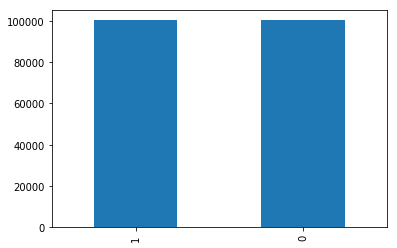

In [36]:
pd.Series(y_train_rf_smote).value_counts().plot.bar()

## Model Evaluation
- In our case we really want to focus our attention on those predicted to abuse opiods.
- We want to avoid the model making false negative (predicted NOT to be an user but actually is an user) at all cost.
- The consequences of false negatives is greater than false positives (predicted to be a user but actually not a user). 
- We want the model to have great Recall.

In [212]:
models = []
models.append(('logReg', LogisticRegression(max_iter=10000, random_state=SEED)))
models.append(('rf_classifer', RandomForestClassifier(random_state=SEED)))
models.append(('knn', KNeighborsClassifier()))
models.append(('gbm', GradientBoostingClassifier(random_state=SEED)))
models.append(('bayes', GaussianNB()))
models.append(('svc', svm.SVC()))

In [213]:
training_results = []
testing_results = []
classifiers = []

for name, classifier in models:
    scores = cross_val_score(classifier, X_train_rf_smote, y_train_rf_smote, cv=3, scoring='recall')
    training_results.append(scores)
    classifiers.append(name)
    print('{}: avg recall using cv w/ RF features on training data: {}'.format(name, scores.mean().round(3)))
    
    
    classifier.fit(X_train_rf_smote, y_train_rf_smote)
    y_preds = classifier.predict(X_test_rf)
    test_recall = recall_score(y_test, y_preds, average='binary')
    testing_results.append(test_recall)
    test_class = classification_report(y_test, y_preds)
    print('{}: recall w/ RF features on testing data {}:'.format(name, test_recall.round(3)))
   
    print(test_class)
    

logReg: avg recall using cv w/ RF features on training data: 0.341
logReg: recall w/ RF features on testing data 0.37:
              precision    recall  f1-score   support

           0       0.87      0.48      0.62     42955
           1       0.08      0.37      0.13      4972

    accuracy                           0.47     47927
   macro avg       0.47      0.43      0.37     47927
weighted avg       0.79      0.47      0.57     47927

rf_classifer: avg recall using cv w/ RF features on training data: 0.975
rf_classifer: recall w/ RF features on testing data 0.805:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     42955
           1       0.81      0.80      0.81      4972

    accuracy                           0.96     47927
   macro avg       0.89      0.89      0.89     47927
weighted avg       0.96      0.96      0.96     47927

knn: avg recall using cv w/ RF features on training data: 0.999
knn: recall w/ RF features on t

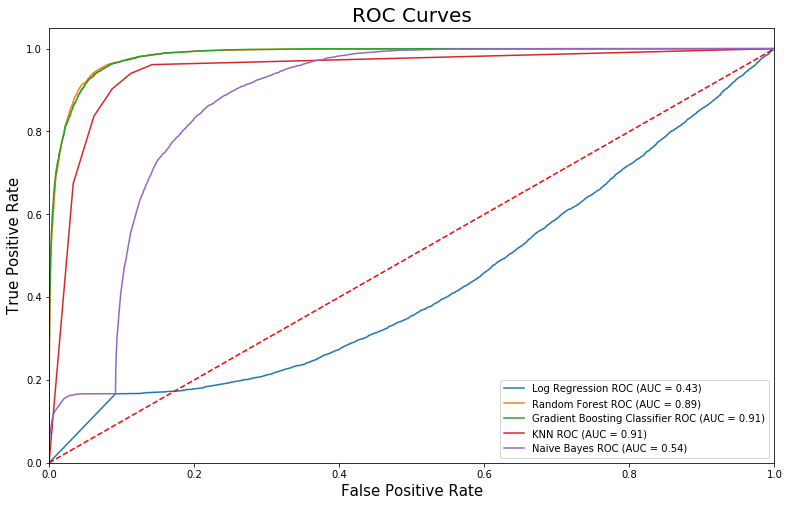

In [226]:
classifiers = [
    {'name': 'Log Regression', 'classifier': LogisticRegression(max_iter=10000, random_state=SEED)},
    {'name': 'Random Forest', 'classifier': RandomForestClassifier()},
    {'name': 'Gradient Boosting Classifier', 'classifier': GradientBoostingClassifier(random_state=SEED)},
    {'name': 'KNN', 'classifier': KNeighborsClassifier()},
    {'name': 'Naive Bayes', 'classifier': GaussianNB()}]

results = pd.DataFrame(columns =['classifier', 'FPR', 'TPR', 'AUC'])
plt.figure(figsize=(13,8))
for clf in classifiers:
    model = clf['classifier']
    model.fit(X_train_rf_smote, y_train_rf_smote)
    y_preds = model.predict(X_test_rf)
    y_proba = model.predict_proba(X_test_rf)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, model.predict(X_test_rf))
    plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (clf['name'], auc))
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC Curves', fontsize=20)
plt.legend(loc="lower right")
plt.show()     

## Hyperparameter Tuning

In [242]:
learning_rates = [0.01, 0.05, 0.1, 0.25, 0.5, 1]
n_estimators = [1, 2, 4, 8, 16, 32]
max_depths = np.linspace(1, 15, 15, endpoint=True)

param_grid = dict(learning_rate=learning_rates, n_estimators=n_estimators, max_depth=max_depths)

grid = GridSearchCV(estimator=GradientBoostingClassifier(random_state=SEED), 
                    param_grid=param_grid, scoring='recall', verbose=1, n_jobs=-1, cv=2)

grid_results = grid.fit(X_train_rf_smote, y_train_rf_smote) 
print('Best Score: ', grid_results.best_score_)
print('Best Params: ', grid_results.best_params_)

Fitting 2 folds for each of 540 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 25.0min finished


Best Score:  0.9803970470869912
Best Params:  {'learning_rate': 0.01, 'max_depth': 2.0, 'n_estimators': 1}


### Training Classifier with Optimized Hyperparameters

In [262]:
gbc_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=2.0, n_estimators=1, random_state=SEED)
                             
gbc_scores = cross_val_score(gbc_clf, X_train_rf_smote, y_train_rf_smote ,cv=3, scoring='recall')
print('Gradient Boosting: avg recall using cv w/ RF features on training data:', gbc_scores.mean().round(3))

gbc_clf.fit(X_train_rf_smote, y_train_rf_smote)

y_preds = gbc_clf.predict(X_test_rf)

test_recall = recall_score(y_test, y_preds, average='binary').round(3)
test_class = classification_report(y_test, y_preds)
cm = confusion_matrix(y_test, y_preds)
print('Gradient Boosting: recall w/ RF features on testing data:', test_recall)
print(test_class)
print(cm)

Gradient Boosting: avg recall using cv w/ RF features on training data: 0.98
Gradient Boosting: recall w/ RF features on testing data: 0.95
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     42955
           1       0.32      0.95      0.48      4972

    accuracy                           0.79     47927
   macro avg       0.66      0.86      0.67     47927
weighted avg       0.92      0.79      0.83     47927

[[32931 10024]
 [  248  4724]]


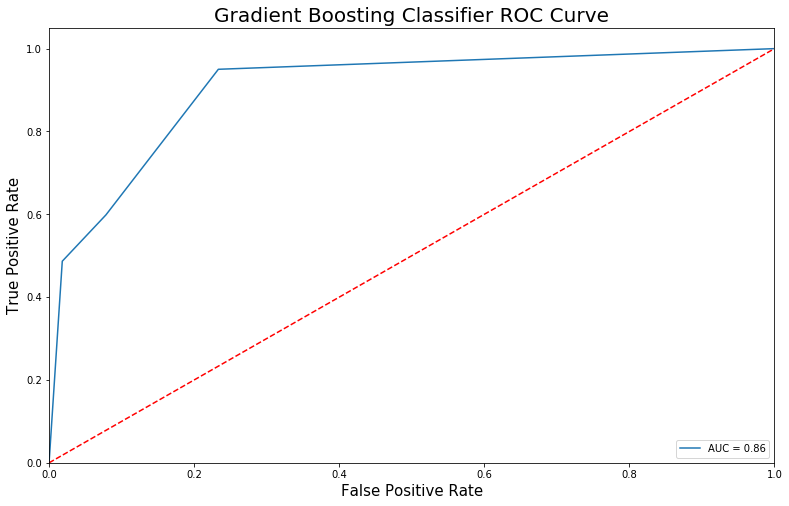

In [261]:
fpr, tpr, thresholds = roc_curve(y_test, gbc_clf.predict_proba(X_test_rf)[:,1])
roc_auc = roc_auc_score(y_test, y_preds).round(3)
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label= 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Gradient Boosting Classifier ROC Curve', fontsize=20)
plt.legend(loc="lower right")
plt.show()     